In [38]:
import os
import pickle
import pandas as pd
from pathlib import Path
from pku_autonomous_driving import geometry, io, util, dataset, resnet, centernet, training, graphics, transform, const

import importlib
importlib.reload(geometry)
importlib.reload(io)
importlib.reload(util)
importlib.reload(dataset)
importlib.reload(resnet)
importlib.reload(centernet)
importlib.reload(training)
importlib.reload(graphics)
importlib.reload(transform)
importlib.reload(const)

<module 'pku_autonomous_driving.const' from '/Users/argon/workspace/managed/pku-autonomous-driving/pku_autonomous_driving/const.py'>

In [27]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
import torchvision
from pku_autonomous_driving.transform import HorizontalFlip, CropBottomHalf, CropFar, PadByMean, Resize, Normalize, DropPointsAtOutOfScreen, CreateMaskAndRegr, ToCHWOrder
from pku_autonomous_driving.const import IMG_WIDTH, IMG_HEIGHT, MODEL_SCALE

near_transform_funcs = [
    CropBottomHalf(),
    Resize(IMG_WIDTH, IMG_HEIGHT),
    Normalize(),
    DropPointsAtOutOfScreen(IMG_WIDTH, IMG_HEIGHT),
    CreateMaskAndRegr(IMG_WIDTH, IMG_HEIGHT, MODEL_SCALE),
    ToCHWOrder()  
]

near_transform = torchvision.transforms.Compose(near_transform_funcs)
near_transform_flip = torchvision.transforms.Compose([
    HorizontalFlip(),
    *near_transform_funcs
])

far_transform_funcs = [
    CropFar(IMG_WIDTH, IMG_HEIGHT),
    Normalize(),
    DropPointsAtOutOfScreen(IMG_WIDTH, IMG_HEIGHT),
    CreateMaskAndRegr(IMG_WIDTH, IMG_HEIGHT, MODEL_SCALE),
    ToCHWOrder()
]

far_transform = torchvision.transforms.Compose(far_transform_funcs)
far_transform_flip = torchvision.transforms.Compose([
    HorizontalFlip(),
    *far_transform_funcs
])

transforms = {
    'NEAR': (near_transform, near_transform_flip),
    'FAR': (far_transform, far_transform_flip)
}

train_transform, train_transform_flip = transforms[os.environ.get("TRANSFORM_TYPE", "NEAR")]

In [29]:
from pku_autonomous_driving.dataset import CarDataset, create_data_loader
from pku_autonomous_driving.const import BATCH_SIZE

train, dev = io.load_train_data()
train = train[:4]
dev = dev[:4]

use_flip_data = False

train_datasets = [CarDataset(train, transform=train_transform)]
if use_flip_data:
    train_datasets.append(CarDataset(train, transform=train_transform_flip))
train_loader = create_data_loader(train_datasets, batch_size=BATCH_SIZE)

dev_dataset = CarDataset(dev, transform=train_transform)
dev_loader = create_data_loader(dev_dataset, batch_size=1)

-9.25794 4.13692 17.5307
screen: [136 144   1]
source: [1.76633929e+03 4.35085714e+02 1.00000000e+00]
vehicle: [-14.99661141   4.92775327  27.62286478]
-9.25794 4.13692 17.5307
screen: [136 152   1]
source: [1.76633929e+03 4.59257143e+02 1.00000000e+00]
vehicle: [-14.92076689   4.99941684  28.02457994]
-9.25794 4.13692 17.5307
screen: [136 160   1]
source: [1.76633929e+03 4.83428571e+02 1.00000000e+00]
vehicle: [-14.84268382   5.07319556  28.4381517 ]
-9.25794 4.13692 17.5307
screen: [144 128   1]
source: [1.79053571e+03 3.86742857e+02 1.00000000e+00]
vehicle: [-11.90315546   3.98727447  21.10926912]
-9.25794 4.13692 17.5307
screen: [144 136   1]
source: [1.79053571e+03 4.10914286e+02 1.00000000e+00]
vehicle: [-11.81113162   4.03143592  21.34306691]
-9.25794 4.13692 17.5307
screen: [144 144   1]
source: [1.79053571e+03 4.35085714e+02 1.00000000e+00]
vehicle: [-11.71704651   4.07658656  21.58210161]
-9.25794 4.13692 17.5307
screen: [144 152   1]
source: [1.79053571e+03 4.59257143e+02 1.

-4.02214 3.18843 11.6069
screen: [192 312   1]
source: [1.93571429e+03 9.42685714e+02 1.00000000e+00]
vehicle: [-3.35272267  2.61703664 10.3913481 ]
-4.02214 3.18843 11.6069
screen: [192 320   1]
source: [1.93571429e+03 9.66857143e+02 1.00000000e+00]
vehicle: [-3.26131855  2.63122526 10.44768623]
-4.02214 3.18843 11.6069
screen: [192 328   1]
source: [1.93571429e+03 9.91028571e+02 1.00000000e+00]
vehicle: [-3.16891791  2.64556858 10.50463858]
-4.02214 3.18843 11.6069
screen: [192 336   1]
source: [1.93571429e+03 1.01520000e+03 1.00000000e+00]
vehicle: [-3.07550436  2.66006912 10.56221524]
-4.02214 3.18843 11.6069
screen: [200 240   1]
source: [1.95991071e+03 7.25142857e+02 1.00000000e+00]
vehicle: [-3.75588729  2.36264328  9.00599978]
-4.02214 3.18843 11.6069
screen: [200 248   1]
source: [1.95991071e+03 7.49314286e+02 1.00000000e+00]
vehicle: [-3.6786192   2.37373694  9.04828695]
-4.02214 3.18843 11.6069
screen: [200 256   1]
source: [1.95991071e+03 7.73485714e+02 1.00000000e+00]
vehi

vehicle: [-1.97990064  1.877489    5.59118134]
-4.02214 3.18843 11.6069
screen: [256 296   1]
source: [2.12928571e+03 8.94342857e+02 1.00000000e+00]
vehicle: [-1.92684774  1.88295228  5.60745104]
-4.02214 3.18843 11.6069
screen: [256 304   1]
source: [2.12928571e+03 9.18514286e+02 1.00000000e+00]
vehicle: [-1.87348518  1.88844744  5.6238157 ]
-18.471 13.0061 74.7029
screen: [112 360   1]
source: [1.69375000e+03 1.08771429e+03 1.00000000e+00]
vehicle: [  31.64289131  -17.89960107 -121.83738954]
-18.471 13.0061 74.7029
screen: [112 368   1]
source: [1.69375000e+03 1.11188571e+03 1.00000000e+00]
vehicle: [  28.55931857  -16.83519088 -114.59225831]
-18.471 13.0061 74.7029
screen: [112 376   1]
source: [1.69375000e+03 1.13605714e+03 1.00000000e+00]
vehicle: [  25.82189478  -15.89026692 -108.16043512]
-18.471 13.0061 74.7029
screen: [120 352   1]
source: [1.71794643e+03 1.06354286e+03 1.00000000e+00]
vehicle: [-110.55448469   64.40378209  409.15387827]
-18.471 13.0061 74.7029
screen: [120 36

vehicle: [ 26.35388758  22.34650181 118.30595664]
4.55504 5.32513 22.3258
screen: [152 688   1]
source: [1.81473214e+03 2.07874286e+03 1.00000000e+00]
vehicle: [ 8.04138894  9.41358153 47.21409279]
4.55504 5.32513 22.3258
screen: [152 696   1]
source: [1.81473214e+03 2.10291429e+03 1.00000000e+00]
vehicle: [ 8.75100512  9.65001559 48.39993476]
4.55504 5.32513 22.3258
screen: [152 704   1]
source: [1.81473214e+03 2.12708571e+03 1.00000000e+00]
vehicle: [ 9.49718548  9.89863233 49.64687926]
4.55504 5.32513 22.3258
screen: [152 712   1]
source: [1.81473214e+03 2.15125714e+03 1.00000000e+00]
vehicle: [10.28283081 10.16039824 50.95977379]
4.55504 5.32513 22.3258
screen: [152 720   1]
source: [1.81473214e+03 2.17542857e+03 1.00000000e+00]
vehicle: [11.11115705 10.43638482 52.34399254]
4.55504 5.32513 22.3258
screen: [152 728   1]
source: [1.81473214e+03 2.19960000e+03 1.00000000e+00]
vehicle: [11.98573935 10.72778326 53.80550994]
4.55504 5.32513 22.3258
screen: [152 736   1]
source: [1.81473

vehicle: [ 5.46565167  3.4476475  12.63640999]
6.7081 4.53077 16.2041
screen: [208 896   1]
source: [1.98410714e+03 2.70720000e+03 1.00000000e+00]
vehicle: [ 5.63514172  3.47040445 12.7198194 ]
6.7081 4.53077 16.2041
screen: [208 904   1]
source: [1.98410714e+03 2.73137143e+03 1.00000000e+00]
vehicle: [ 5.80688415  3.49346383 12.80433725]
6.7081 4.53077 16.2041
screen: [208 912   1]
source: [1.98410714e+03 2.75554286e+03 1.00000000e+00]
vehicle: [ 5.98092417  3.5168317  12.88998579]
6.7081 4.53077 16.2041
screen: [216 832   1]
source: [2.00830357e+03 2.51382857e+03 1.00000000e+00]
vehicle: [ 3.86550378  3.04975826 10.76406322]
6.7081 4.53077 16.2041
screen: [216 840   1]
source: [2.00830357e+03 2.53800000e+03 1.00000000e+00]
vehicle: [ 4.00075096  3.06688934 10.82452703]
6.7081 4.53077 16.2041
screen: [216 848   1]
source: [2.00830357e+03 2.56217143e+03 1.00000000e+00]
vehicle: [ 4.13752613  3.08421397 10.88567396]
6.7081 4.53077 16.2041
screen: [216 856   1]
source: [2.00830357e+03 2.

vehicle: [ 0.99223502  3.29150269 13.06941973]
0.943844 4.09512 17.1992
screen: [192 624   1]
source: [1.93571429e+03 1.88537143e+03 1.00000000e+00]
vehicle: [ 1.13702612  3.31397856 13.15866362]
0.943844 4.09512 17.1992
screen: [200 560   1]
source: [1.95991071e+03 1.69200000e+03 1.00000000e+00]
vehicle: [ 0.02769516  2.90586596 11.07667349]
0.943844 4.09512 17.1992
screen: [200 568   1]
source: [1.95991071e+03 1.71617143e+03 1.00000000e+00]
vehicle: [ 0.14470549  2.92266556 11.14071073]
0.943844 4.09512 17.1992
screen: [200 576   1]
source: [1.95991071e+03 1.74034286e+03 1.00000000e+00]
vehicle: [ 0.26307661  2.93966053 11.20549272]
0.943844 4.09512 17.1992
screen: [200 584   1]
source: [1.95991071e+03 1.76451429e+03 1.00000000e+00]
vehicle: [ 0.38283242  2.95685431 11.27103251]
0.943844 4.09512 17.1992
screen: [200 592   1]
source: [1.95991071e+03 1.78868571e+03 1.00000000e+00]
vehicle: [ 0.50399735  2.9742504  11.33734348]
0.943844 4.09512 17.1992
screen: [200 600   1]
source: [1.9

-8.35845 5.38667 25.7284
screen: [120 296   1]
source: [1.71794643e+03 8.94342857e+02 1.00000000e+00]
vehicle: [-56.54859883  25.90386933 164.5659347 ]
-8.35845 5.38667 25.7284
screen: [120 304   1]
source: [1.71794643e+03 9.18514286e+02 1.00000000e+00]
vehicle: [-59.94144697  28.32257528 179.93184783]
-8.35845 5.38667 25.7284
screen: [120 312   1]
source: [1.71794643e+03 9.42685714e+02 1.00000000e+00]
vehicle: [-64.03314501  31.23947989 198.46279115]
-8.35845 5.38667 25.7284
screen: [128 280   1]
source: [1.74214286e+03 8.46000000e+02 1.00000000e+00]
vehicle: [-21.13959273   9.73491941  57.98024766]
-8.35845 5.38667 25.7284
screen: [128 288   1]
source: [1.74214286e+03 8.70171429e+02 1.00000000e+00]
vehicle: [-21.16837219  10.0369079   59.77886222]
-8.35845 5.38667 25.7284
screen: [128 296   1]
source: [1.74214286e+03 8.94342857e+02 1.00000000e+00]
vehicle: [-21.19899435  10.35823229  61.69263948]
-8.35845 5.38667 25.7284
screen: [128 304   1]
source: [1.74214286e+03 9.18514286e+02 1.

-4.83028 16.4296 88.1935
screen: [144 496   1]
source: [1.79053571e+03 1.49862857e+03 1.00000000e+00]
vehicle: [-3.4639348   8.03718419 42.55013929]
-4.83028 16.4296 88.1935
screen: [144 504   1]
source: [1.79053571e+03 1.52280000e+03 1.00000000e+00]
vehicle: [-3.08578032  8.21865729 43.5108869 ]
-4.83028 16.4296 88.1935
screen: [144 512   1]
source: [1.79053571e+03 1.54697143e+03 1.00000000e+00]
vehicle: [-2.69015451  8.40851473 44.51602256]
-4.83028 16.4296 88.1935
screen: [144 520   1]
source: [1.79053571e+03 1.57114286e+03 1.00000000e+00]
vehicle: [-2.27581794  8.6073513  45.56869521]
-4.83028 16.4296 88.1935
screen: [144 528   1]
source: [1.79053571e+03 1.59531429e+03 1.00000000e+00]
vehicle: [-1.84141108  8.81581943 46.67235886]
-4.83028 16.4296 88.1935
screen: [152 504   1]
source: [1.81473214e+03 1.52280000e+03 1.00000000e+00]
vehicle: [-2.14158385  6.02075911 30.19729296]
-4.83028 16.4296 88.1935
screen: [152 512   1]
source: [1.81473214e+03 1.54697143e+03 1.00000000e+00]
vehi

5.81972 3.11018 8.87054
screen: [ 240 1032    1]
source: [2.08089286e+03 3.11811429e+03 1.00000000e+00]
vehicle: [5.63168977 2.85341265 9.06397958]
5.81972 3.11018 8.87054
screen: [ 240 1040    1]
source: [2.08089286e+03 3.14228571e+03 1.00000000e+00]
vehicle: [5.75382163 2.86689736 9.10681429]
5.81972 3.11018 8.87054
screen: [ 240 1048    1]
source: [2.08089286e+03 3.16645714e+03 1.00000000e+00]
vehicle: [5.87711332 2.88051012 9.15005577]
5.81972 3.11018 8.87054
screen: [ 240 1056    1]
source: [2.08089286e+03 3.19062857e+03 1.00000000e+00]
vehicle: [6.00158144 2.89425277 9.19370986]
5.81972 3.11018 8.87054
screen: [ 240 1064    1]
source: [2.08089286e+03 3.21480000e+03 1.00000000e+00]
vehicle: [6.1272429  2.90812718 9.23778249]
5.81972 3.11018 8.87054
screen: [ 240 1072    1]
source: [2.08089286e+03 3.23897143e+03 1.00000000e+00]
vehicle: [6.25411495 2.92213526 9.2822797 ]
5.81972 3.11018 8.87054
screen: [ 240 1080    1]
source: [2.08089286e+03 3.26314286e+03 1.00000000e+00]
vehicle:

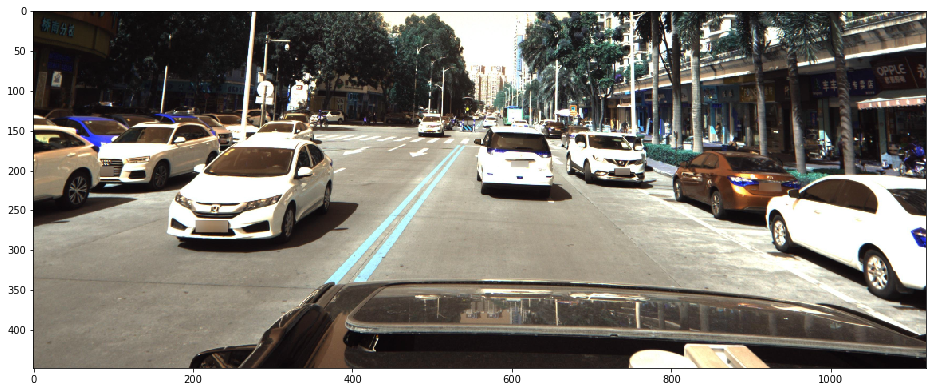

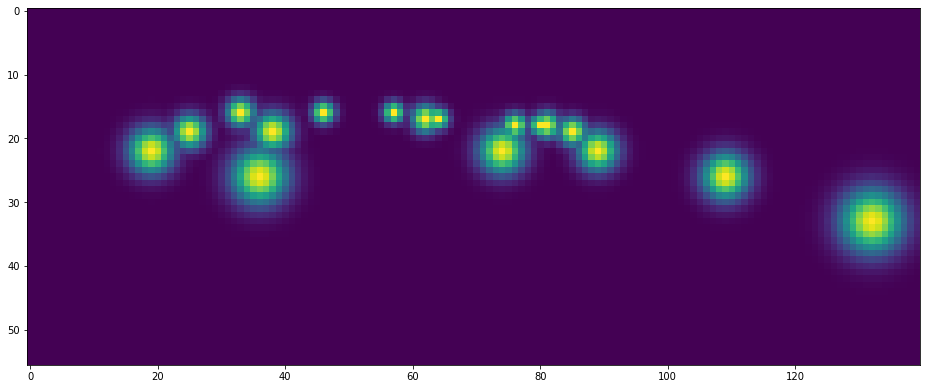

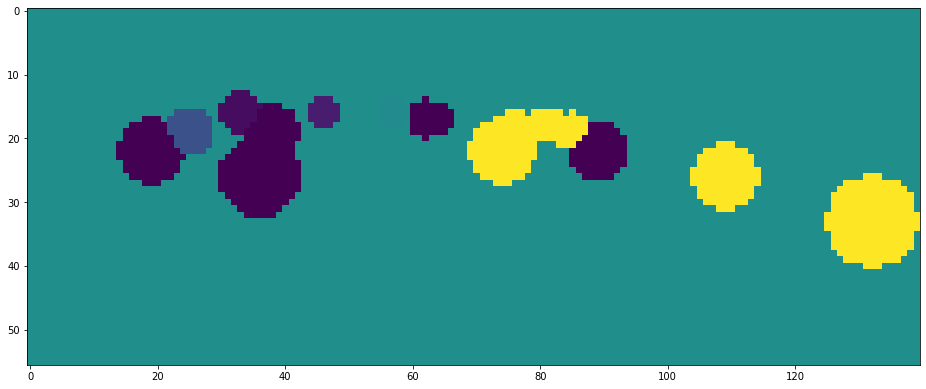

In [30]:
import matplotlib.pyplot as plt
import numpy as np

data = train_loader.dataset[0]
img, mask, regr = data["img"], data["mask"], data["regr"]
plt.figure(figsize=(16,16))
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(regr[-2])
plt.show()

In [ ]:
from torch import optim

output_channles = train_loader.dataset[0]["regr"].shape[0] + 1
base_model = resnet.resnext50_32x4d(pretrained=False)
model = centernet.CentResnet(base_model, output_channles)

optimizer = optim.AdamW(model.parameters(), lr=0.001)
#optimizer =  RAdam(model.parameters(), lr = 0.001)

setup_kwargs = {
    "model": model,
    "optimizer": optimizer,
    "device": device,
#    "path" : Path("./res_mask_1/resnext50.pth")
}

training.setup(**setup_kwargs)

In [ ]:
n_epochs = int(os.environ.get("N_EPOCHS", 6))
n_epochs = 2
try:
    history = pickle.load(Path(os.environ["INITIAL_HISTORY"]).open('rb'))
    beg_epoch = math.ceil(history.index[-1])
except:
    history = pd.DataFrame()
    beg_epoch = 0
end_epoch = beg_epoch + n_epochs

In [20]:
%%time
from torch.optim import lr_scheduler
import pandas as pd
import pickle

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 3, gamma=0.1)

best_dev_loss = np.inf
for epoch in range(beg_epoch, end_epoch):
    training.clean_up()
    training.train(model, optimizer, exp_lr_scheduler, train_loader, epoch, device, history)
    training.evaluate(model, dev_loader, epoch, device, history)
    training.save_checkpoint(model, optimizer, history)

    cur_dev_loss = history['dev_loss'].dropna().iloc[-1]
    if cur_dev_loss < best_dev_loss:
        torch.save({"model": model.state_dict()}, './resnext50.pth')
        best_dev_loss = cur_dev_loss

-9.25794 4.13692 17.5307
screen: [136 144   1]
source: [1.76633929e+03 4.35085714e+02 1.00000000e+00]
vehicle: [-14.99661141   4.92775327  27.62286478]
-9.25794 4.13692 17.5307
screen: [136 152   1]
source: [1.76633929e+03 4.59257143e+02 1.00000000e+00]
vehicle: [-14.92076689   4.99941684  28.02457994]
-9.25794 4.13692 17.5307
screen: [136 160   1]
source: [1.76633929e+03 4.83428571e+02 1.00000000e+00]
vehicle: [-14.84268382   5.07319556  28.4381517 ]
-9.25794 4.13692 17.5307
screen: [144 128   1]
source: [1.79053571e+03 3.86742857e+02 1.00000000e+00]
vehicle: [-11.90315546   3.98727447  21.10926912]
-9.25794 4.13692 17.5307
screen: [144 136   1]
source: [1.79053571e+03 4.10914286e+02 1.00000000e+00]
vehicle: [-11.81113162   4.03143592  21.34306691]
-9.25794 4.13692 17.5307
screen: [144 144   1]
source: [1.79053571e+03 4.35085714e+02 1.00000000e+00]
vehicle: [-11.71704651   4.07658656  21.58210161]
-9.25794 4.13692 17.5307
screen: [144 152   1]
source: [1.79053571e+03 4.59257143e+02 1.

screen: [216 256   1]
source: [2.00830357e+03 7.73485714e+02 1.00000000e+00]
vehicle: [-3.04046508  2.17501388  7.67666972]
-4.02214 3.18843 11.6069
screen: [216 264   1]
source: [2.00830357e+03 7.97657143e+02 1.00000000e+00]
vehicle: [-2.97178635  2.18371307  7.70737334]
-4.02214 3.18843 11.6069
screen: [216 272   1]
source: [2.00830357e+03 8.21828571e+02 1.00000000e+00]
vehicle: [-2.90255604  2.19248213  7.73832356]
-4.02214 3.18843 11.6069
screen: [216 280   1]
source: [2.00830357e+03 8.46000000e+02 1.00000000e+00]
vehicle: [-2.83276747  2.20132189  7.76952335]
-4.02214 3.18843 11.6069
screen: [216 288   1]
source: [2.00830357e+03 8.70171429e+02 1.00000000e+00]
vehicle: [-2.76241387  2.21023323  7.80097574]
-4.02214 3.18843 11.6069
screen: [216 296   1]
source: [2.00830357e+03 8.94342857e+02 1.00000000e+00]
vehicle: [-2.69148834  2.21921701  7.83268382]
-4.02214 3.18843 11.6069
screen: [216 304   1]
source: [2.00830357e+03 9.18514286e+02 1.00000000e+00]
vehicle: [-2.6199839   2.2282

ValueError: math domain error

In [ ]:
history['train_loss'].iloc[:].plot();

In [ ]:
series1 = history.dropna()['mask_loss']
plt.plot(series1.index, series1 ,label = 'mask loss');
series2 = history.dropna()['regr_loss']
plt.plot(series2.index, 30*series2,label = 'regr loss');
series3 = history.dropna()['dev_loss']
plt.plot(series3.index, series3,label = 'dev loss');
plt.show()

In [ ]:
series = history.dropna()['dev_loss']
plt.scatter(series.index, series);

In [ ]:
data = train_loader.dataset[0]
img, mask, regr = data["img"], data["mask"], data["regr"]

model.eval()

plt.figure(figsize=(16,16))
plt.title('Input image')
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.title('Ground truth mask')
plt.imshow(mask)
plt.show()

output = model(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

plt.figure(figsize=(16,16))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Model predictions thresholded')
plt.imshow(logits > 0)
plt.show()

-1.61091 4.65303 19.9246
screen: [144 480   1]
source: [1.79053571e+03 1.45028571e+03 1.00000000e+00]
vehicle: [-4.17226332  7.69726341 40.75054424]
-1.61091 4.65303 19.9246
screen: [144 488   1]
source: [1.79053571e+03 1.47445714e+03 1.00000000e+00]
vehicle: [-3.82575028  7.86355204 41.6309029 ]
-1.61091 4.65303 19.9246
screen: [144 496   1]
source: [1.79053571e+03 1.49862857e+03 1.00000000e+00]
vehicle: [-3.4639348   8.03718419 42.55013929]
-1.61091 4.65303 19.9246
screen: [144 504   1]
source: [1.79053571e+03 1.52280000e+03 1.00000000e+00]
vehicle: [-3.08578032  8.21865729 43.5108869 ]
-1.61091 4.65303 19.9246
screen: [144 512   1]
source: [1.79053571e+03 1.54697143e+03 1.00000000e+00]
vehicle: [-2.69015451  8.40851473 44.51602256]
-1.61091 4.65303 19.9246
screen: [152 472   1]
source: [1.81473214e+03 1.42611429e+03 1.00000000e+00]
vehicle: [-3.20744354  5.66562974 28.41613127]
-1.61091 4.65303 19.9246
screen: [152 480   1]
source: [1.81473214e+03 1.45028571e+03 1.00000000e+00]
vehi

screen: [224 728   1]
source: [2.0325e+03 2.1996e+03 1.0000e+00]
vehicle: [2.02914155 2.67643902 9.10907477]
4.61943 5.1905 20.4466
screen: [224 736   1]
source: [2.03250000e+03 2.22377143e+03 1.00000000e+00]
vehicle: [2.13477384 2.6891506  9.15233777]
4.61943 5.1905 20.4466
screen: [224 744   1]
source: [2.03250000e+03 2.24794286e+03 1.00000000e+00]
vehicle: [2.24141431 2.70198351 9.19601369]
12.3663 5.10021 19.178
screen: [ 168 1032    1]
source: [1.86312500e+03 3.11811429e+03 1.00000000e+00]
vehicle: [32.47638155 11.51848617 52.26943798]
12.3663 5.10021 19.178
screen: [ 168 1040    1]
source: [1.86312500e+03 3.14228571e+03 1.00000000e+00]
vehicle: [33.94535699 11.83962754 53.72673705]
12.3663 5.10021 19.178
screen: [ 168 1048    1]
source: [1.86312500e+03 3.16645714e+03 1.00000000e+00]
vehicle: [35.49859325 12.17918967 55.2676272 ]
12.3663 5.10021 19.178
screen: [ 168 1056    1]
source: [1.86312500e+03 3.19062857e+03 1.00000000e+00]
vehicle: [37.14355426 12.53880429 56.89951299]
12.

source: [1.81473214e+03 1.64365714e+03 1.00000000e+00]
vehicle: [-0.6053834   6.53259935 32.76444266]
0.0636926 11.1433 60.1279
screen: [152 552   1]
source: [1.81473214e+03 1.66782857e+03 1.00000000e+00]
vehicle: [-0.26625805  6.64559112 33.33115615]
0.0636926 11.1433 60.1279
screen: [152 560   1]
source: [1.81473214e+03 1.69200000e+03 1.00000000e+00]
vehicle: [ 0.08480521  6.76256043 33.91781914]
16.667 10.125 51.7967
screen: [120 800   1]
source: [1.71794643e+03 2.41714286e+03 1.00000000e+00]
vehicle: [-11.91599854  -5.91398145 -37.57121657]
16.667 10.125 51.7967
screen: [128 784   1]
source: [1.74214286e+03 2.36880000e+03 1.00000000e+00]
vehicle: [-19.17589488 -10.87054928 -64.7439504 ]
16.667 10.125 51.7967
screen: [128 792   1]
source: [1.74214286e+03 2.39297143e+03 1.00000000e+00]
vehicle: [-19.20956943 -10.51719566 -62.6394101 ]
16.667 10.125 51.7967
screen: [128 800   1]
source: [1.74214286e+03 2.41714286e+03 1.00000000e+00]
vehicle: [-19.24112367 -10.18609077 -60.66738109]
16

[1.74214286e+03 5.80114286e+02 1.00000000e+00] [-20.66373336   4.74163321  28.24071328]
[1.76633929e+03 1.66782857e+03 1.00000000e+00] [-16.06625515   3.91707394  21.95743127]
[1.79053571e+03 2.41714286e+03 1.00000000e+00] [-13.14223633   3.39265017  17.96123292]
[1.86312500e+03 2.61051429e+03 1.00000000e+00] [-8.50084037  2.56021424 11.61792941]
[1.88732143e+03 1.49862857e+03 1.00000000e+00] [-7.60550425  2.3996354  10.39429135]
[1.93571429e+03 2.19960000e+03 1.00000000e+00] [-6.28218417  2.16229749  8.58573611]
[1.95991071e+03 3.16645714e+03 1.00000000e+00] [-5.77939142  2.07212144  7.89857927]


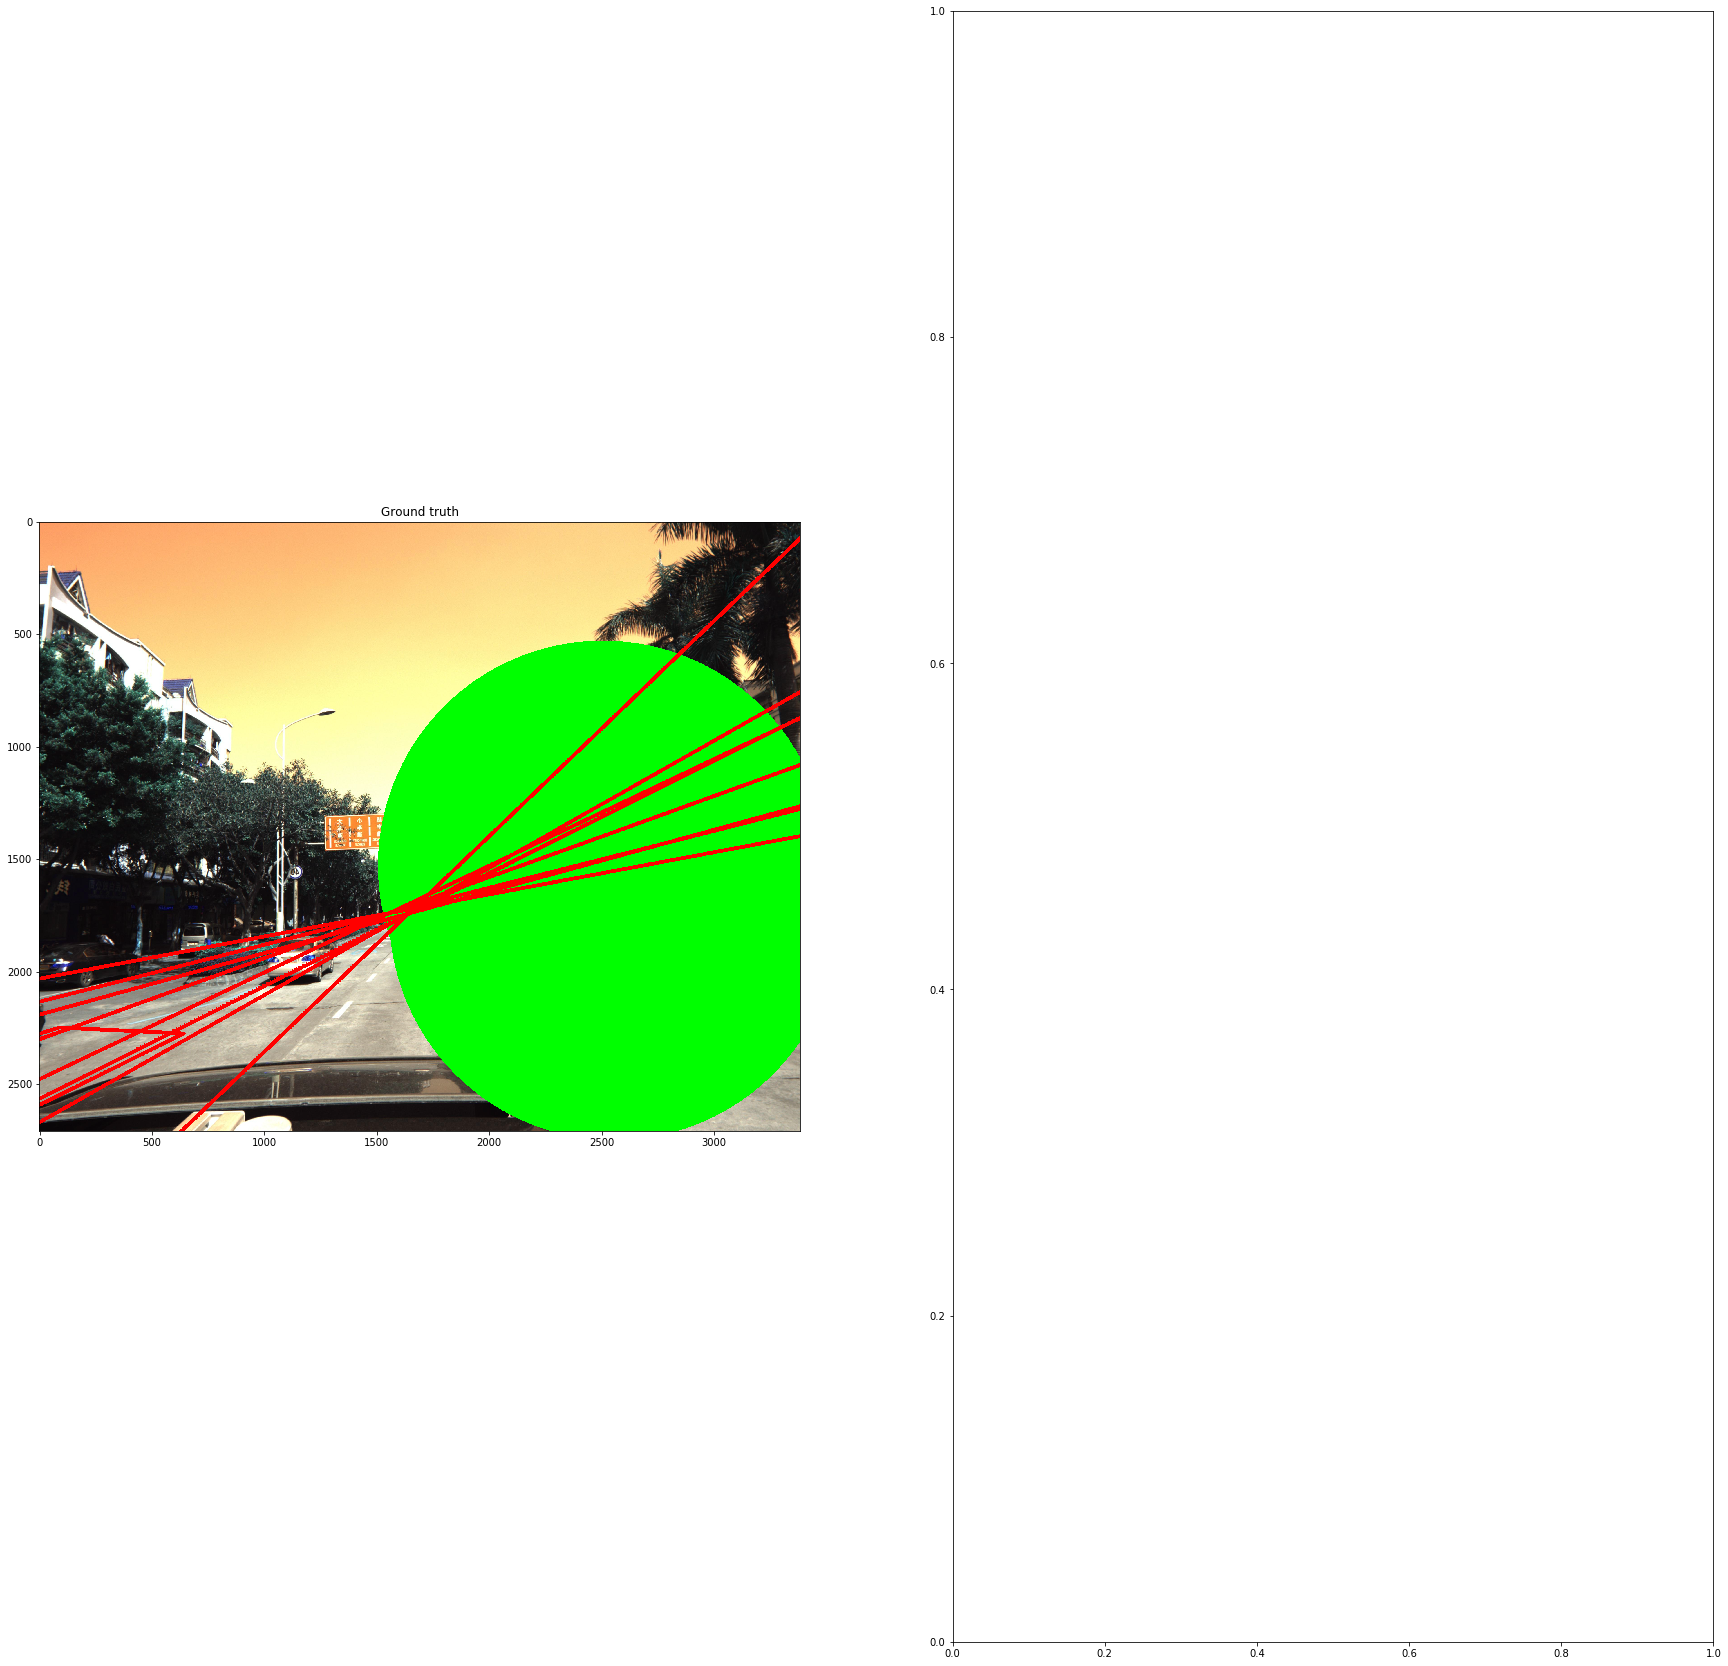

-9.99705 3.62436 15.556
screen: [136  48   1]
source: [1.76633929e+03 1.45028571e+02 1.00000000e+00]
vehicle: [-15.76203666   4.2045223   23.56874311]
-9.99705 3.62436 15.556
screen: [136  56   1]
source: [1.76633929e+03 1.69200000e+02 1.00000000e+00]
vehicle: [-15.70693894   4.25658274  23.86057158]
-9.99705 3.62436 15.556
screen: [136  64   1]
source: [1.76633929e+03 1.93371429e+02 1.00000000e+00]
vehicle: [-15.65045966   4.30994858  24.1597175 ]
-9.99705 3.62436 15.556
screen: [136  72   1]
source: [1.76633929e+03 2.17542857e+02 1.00000000e+00]
vehicle: [-15.59254622   4.36466953  24.46645959]
-9.99705 3.62436 15.556
screen: [136  80   1]
source: [1.76633929e+03 2.41714286e+02 1.00000000e+00]
vehicle: [-15.53314328   4.42079787  24.7810909 ]
-9.99705 3.62436 15.556
screen: [144  40   1]
source: [1.79053571e+03 1.20857143e+02 1.00000000e+00]
vehicle: [-12.79666399   3.55848738  18.83920163]
-9.99705 3.62436 15.556
screen: [144  48   1]
source: [1.79053571e+03 1.45028571e+02 1.0000000

vehicle: [ 11.55695884 -10.96619201 -74.64368632]
-7.47688 9.35672 54.6459
screen: [112 448   1]
source: [1.69375e+03 1.35360e+03 1.00000e+00]
vehicle: [ 10.37228246 -10.55725675 -71.86018271]
-7.47688 9.35672 54.6459
screen: [112 456   1]
source: [1.69375000e+03 1.37777143e+03 1.00000000e+00]
vehicle: [  9.2727842  -10.1777239  -69.27681273]
-7.47688 9.35672 54.6459
screen: [112 464   1]
source: [1.69375000e+03 1.40194286e+03 1.00000000e+00]
vehicle: [  8.24959639  -9.82453245 -66.87274103]
-7.47688 9.35672 54.6459
screen: [120 432   1]
source: [1.71794643e+03 1.30525714e+03 1.00000000e+00]
vehicle: [  60.21923885  -57.3380124  -364.26541093]
-7.47688 9.35672 54.6459
screen: [120 440   1]
source: [1.71794643e+03 1.32942857e+03 1.00000000e+00]
vehicle: [  47.4324975   -48.22255362 -306.35537532]
-7.47688 9.35672 54.6459
screen: [120 448   1]
source: [1.71794643e+03 1.35360000e+03 1.00000000e+00]
vehicle: [  38.15368467  -41.60783971 -264.33244187]
-7.47688 9.35672 54.6459
screen: [120 

vehicle: [ 1.48410246  5.66903104 27.01157538]
5.07368 14.8444 81.9312
screen: [120 592   1]
source: [1.71794643e+03 1.78868571e+03 1.00000000e+00]
vehicle: [ -3.38730561 -11.99394715 -76.19692249]
5.07368 14.8444 81.9312
screen: [120 600   1]
source: [1.71794643e+03 1.81285714e+03 1.00000000e+00]
vehicle: [ -4.02726096 -11.53773345 -73.29862056]
5.07368 14.8444 81.9312
screen: [120 608   1]
source: [1.71794643e+03 1.83702857e+03 1.00000000e+00]
vehicle: [ -4.62031629 -11.114954   -70.61272474]
5.07368 14.8444 81.9312
screen: [128 584   1]
source: [1.74214286e+03 1.76451429e+03 1.00000000e+00]
vehicle: [ -13.73941944  -67.91655784 -404.50451395]
5.07368 14.8444 81.9312
screen: [128 592   1]
source: [1.74214286e+03 1.78868571e+03 1.00000000e+00]
vehicle: [ -14.86233842  -56.1335476  -334.32603344]
5.07368 14.8444 81.9312
screen: [128 600   1]
source: [1.74214286e+03 1.81285714e+03 1.00000000e+00]
vehicle: [ -15.65322635  -47.83460468 -284.89832421]
5.07368 14.8444 81.9312
screen: [128 6

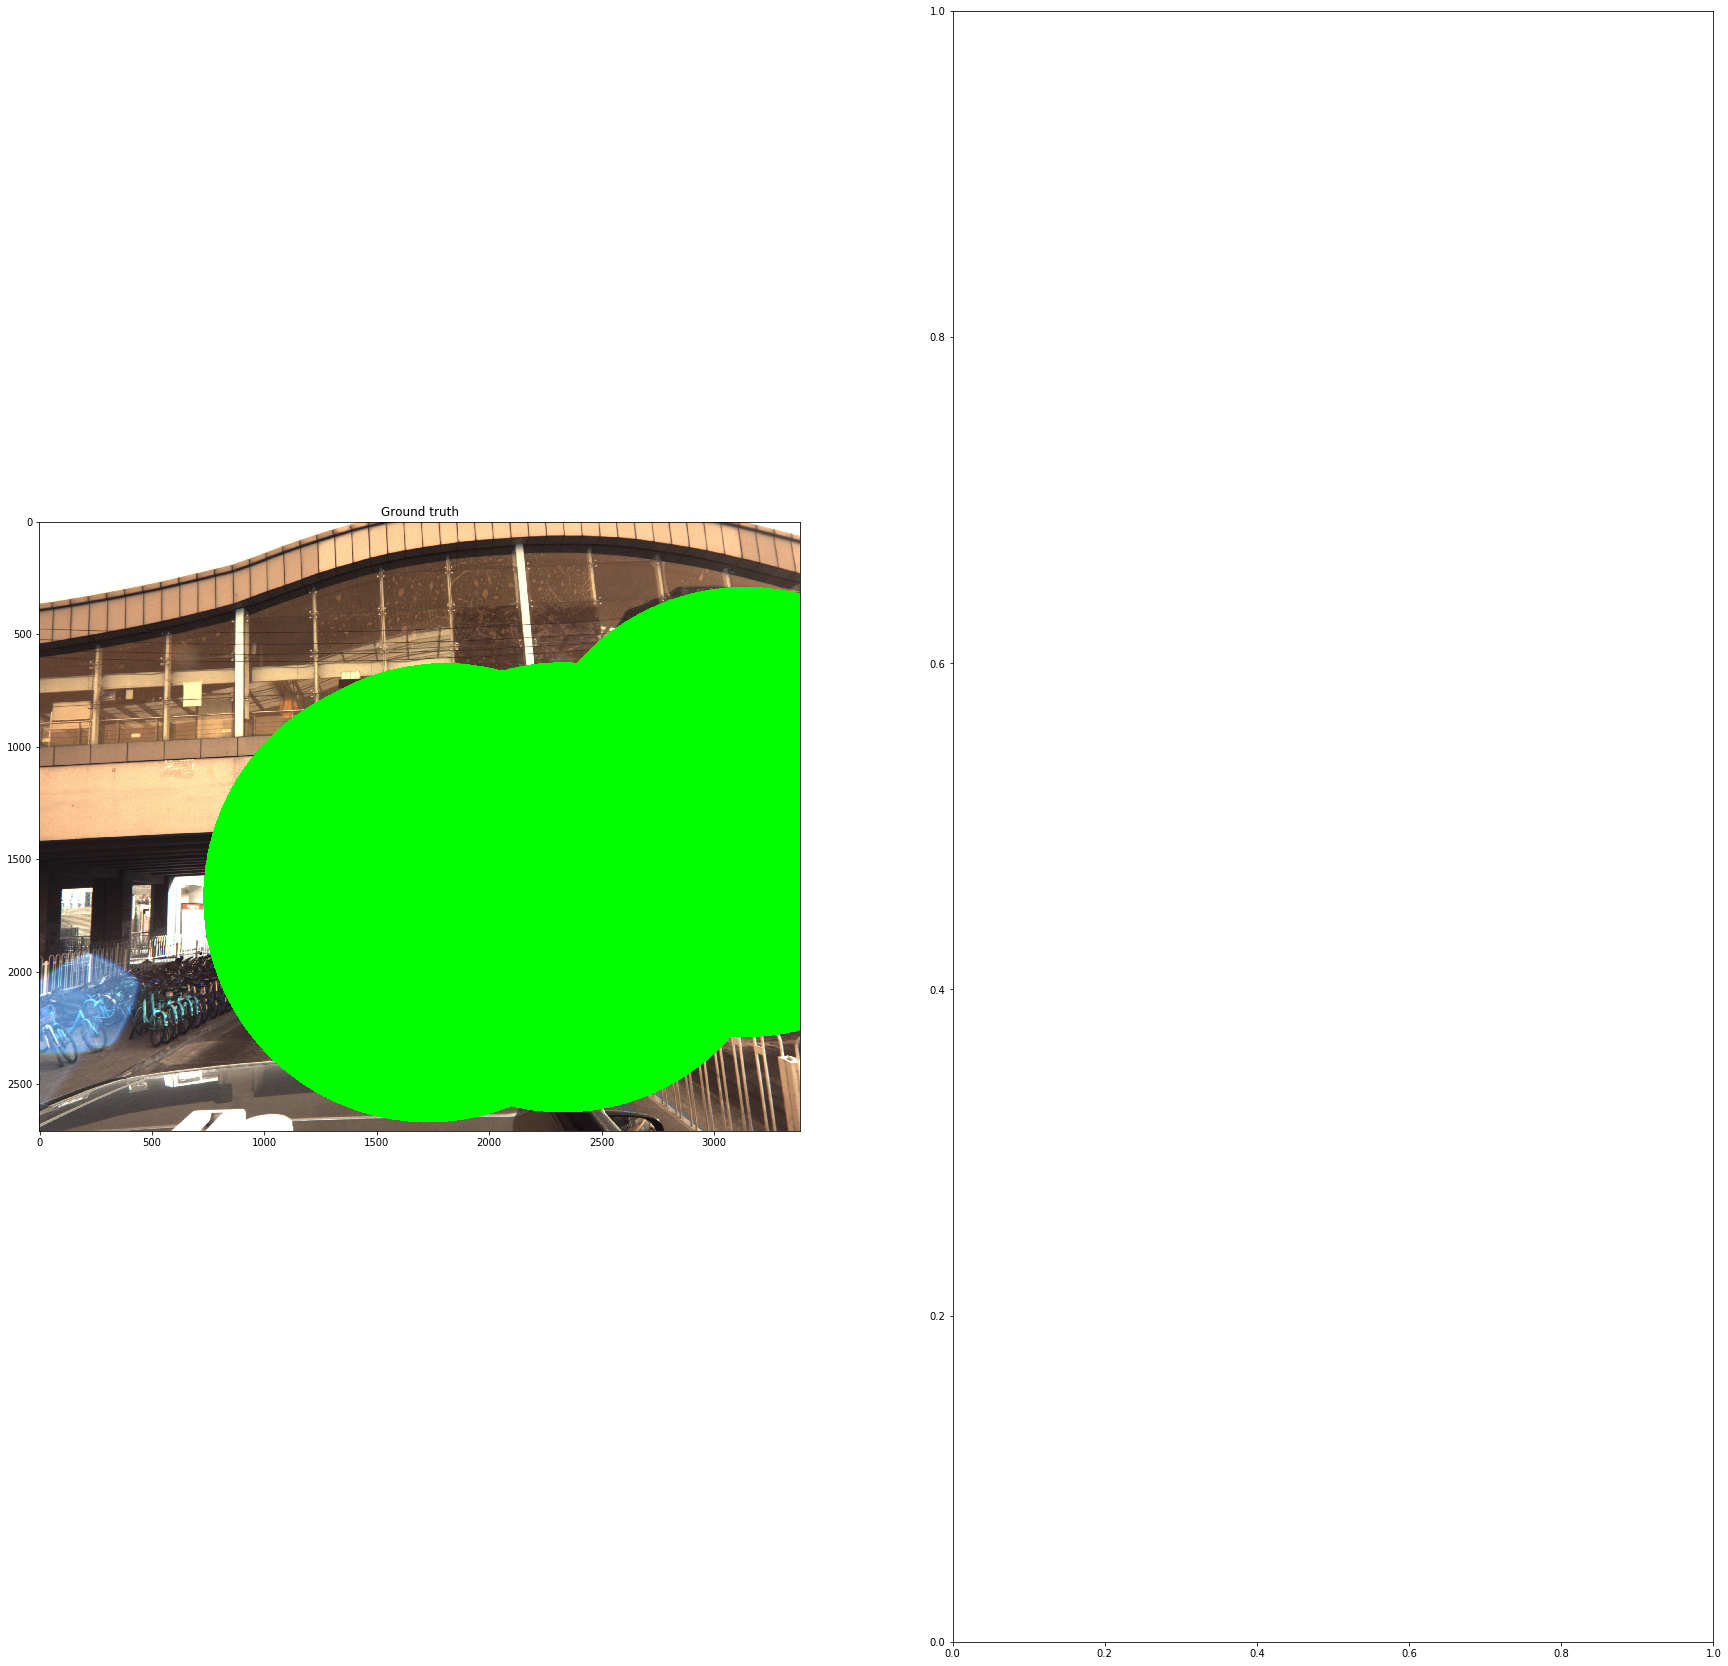

6.71508 4.0828 13.7339
screen: [184 904   1]
source: [1.91151786e+03 2.73137143e+03 1.00000000e+00]
vehicle: [ 9.50750067  5.05982272 20.96429717]
6.71508 4.0828 13.7339
screen: [184 912   1]
source: [1.91151786e+03 2.75554286e+03 1.00000000e+00]
vehicle: [ 9.83437492  5.11547419 21.19487715]
6.71508 4.0828 13.7339
screen: [184 920   1]
source: [1.91151786e+03 2.77971429e+03 1.00000000e+00]
vehicle: [10.16851951  5.17236345 21.4305857 ]
6.71508 4.0828 13.7339
screen: [184 928   1]
source: [1.91151786e+03 2.80388571e+03 1.00000000e+00]
vehicle: [10.51017975  5.23053228 21.67159585]
6.71508 4.0828 13.7339
screen: [184 936   1]
source: [1.91151786e+03 2.82805714e+03 1.00000000e+00]
vehicle: [10.85961206  5.29002434 21.91808849]
6.71508 4.0828 13.7339
screen: [184 944   1]
source: [1.91151786e+03 2.85222857e+03 1.00000000e+00]
vehicle: [11.21708471  5.35088528 22.17025286]
6.71508 4.0828 13.7339
screen: [184 952   1]
source: [1.91151786e+03 2.87640000e+03 1.00000000e+00]
vehicle: [11.58287

screen: [176 680   1]
source: [1.88732143e+03 2.05457143e+03 1.00000000e+00]
vehicle: [ 3.06788542  4.43132888 19.19480079]
3.39593 4.7945 20.1083
screen: [176 688   1]
source: [1.88732143e+03 2.07874286e+03 1.00000000e+00]
vehicle: [ 3.30210315  4.47591253 19.38791989]
3.39593 4.7945 20.1083
screen: [176 696   1]
source: [1.88732143e+03 2.10291429e+03 1.00000000e+00]
vehicle: [ 3.54108171  4.52140241 19.58496442]
3.39593 4.7945 20.1083
screen: [176 704   1]
source: [1.88732143e+03 2.12708571e+03 1.00000000e+00]
vehicle: [ 3.78496776  4.56782643 19.78605531]
3.39593 4.7945 20.1083
screen: [176 712   1]
source: [1.88732143e+03 2.15125714e+03 1.00000000e+00]
vehicle: [ 4.03391402  4.61521367 19.99131849]
3.39593 4.7945 20.1083
screen: [184 648   1]
source: [1.91151786e+03 1.95788571e+03 1.00000000e+00]
vehicle: [ 1.8330285   3.75321745 15.55065668]
3.39593 4.7945 20.1083
screen: [184 656   1]
source: [1.91151786e+03 1.98205714e+03 1.00000000e+00]
vehicle: [ 2.01237208  3.78375131 15.6771

screen: [136 624   1]
source: [1.76633929e+03 1.88537143e+03 1.00000000e+00]
vehicle: [ 17.0567154   35.21413175 197.39527267]
2.5108 8.71019 44.4974
screen: [144 576   1]
source: [1.79053571e+03 1.74034286e+03 1.00000000e+00]
vehicle: [ 1.28205547 10.31474428 54.60790689]
2.5108 8.71019 44.4974
screen: [144 584   1]
source: [1.79053571e+03 1.76451429e+03 1.00000000e+00]
vehicle: [ 1.908909   10.61556592 56.20050479]
2.5108 8.71019 44.4974
screen: [144 592   1]
source: [1.79053571e+03 1.78868571e+03 1.00000000e+00]
vehicle: [ 2.57342432 10.93446113 57.88878706]
2.5108 8.71019 44.4974
screen: [144 600   1]
source: [1.79053571e+03 1.81285714e+03 1.00000000e+00]
vehicle: [ 3.27910065 11.27310916 59.68164393]
2.5108 8.71019 44.4974
screen: [144 608   1]
source: [1.79053571e+03 1.83702857e+03 1.00000000e+00]
vehicle: [ 4.0298846  11.63340395 61.58910219]
2.5108 8.71019 44.4974
screen: [144 616   1]
source: [1.79053571e+03 1.86120000e+03 1.00000000e+00]
vehicle: [ 4.83024394 12.01748955 63.6

screen: [192   8   1]
source: [1.93571429e+03 2.41714286e+01 1.00000000e+00]
vehicle: [-6.21984398  2.17197454  8.62416031]
-14.3589 4.97064 20.8461
screen: [192  16   1]
source: [1.93571429e+03 4.83428571e+01 1.00000000e+00]
vehicle: [-6.15694329  2.18173858  8.66292997]
-14.3589 4.97064 20.8461
screen: [192  24   1]
source: [1.93571429e+03 7.25142857e+01 1.00000000e+00]
vehicle: [-6.09347451  2.19159082  8.70204978]
-14.3589 4.97064 20.8461
screen: [192  32   1]
source: [1.93571429e+03 9.66857143e+01 1.00000000e+00]
vehicle: [-6.02942992  2.20153244  8.74152451]
-14.3589 4.97064 20.8461
screen: [192  40   1]
source: [1.93571429e+03 1.20857143e+02 1.00000000e+00]
vehicle: [-5.96480163  2.21156466  8.781359  ]
-14.3589 4.97064 20.8461
screen: [192  48   1]
source: [1.93571429e+03 1.45028571e+02 1.00000000e+00]
vehicle: [-5.89958163  2.22168873  8.8215582 ]
-14.3589 4.97064 20.8461
screen: [192  56   1]
source: [1.93571429e+03 1.69200000e+02 1.00000000e+00]
vehicle: [-5.83376175  2.2319

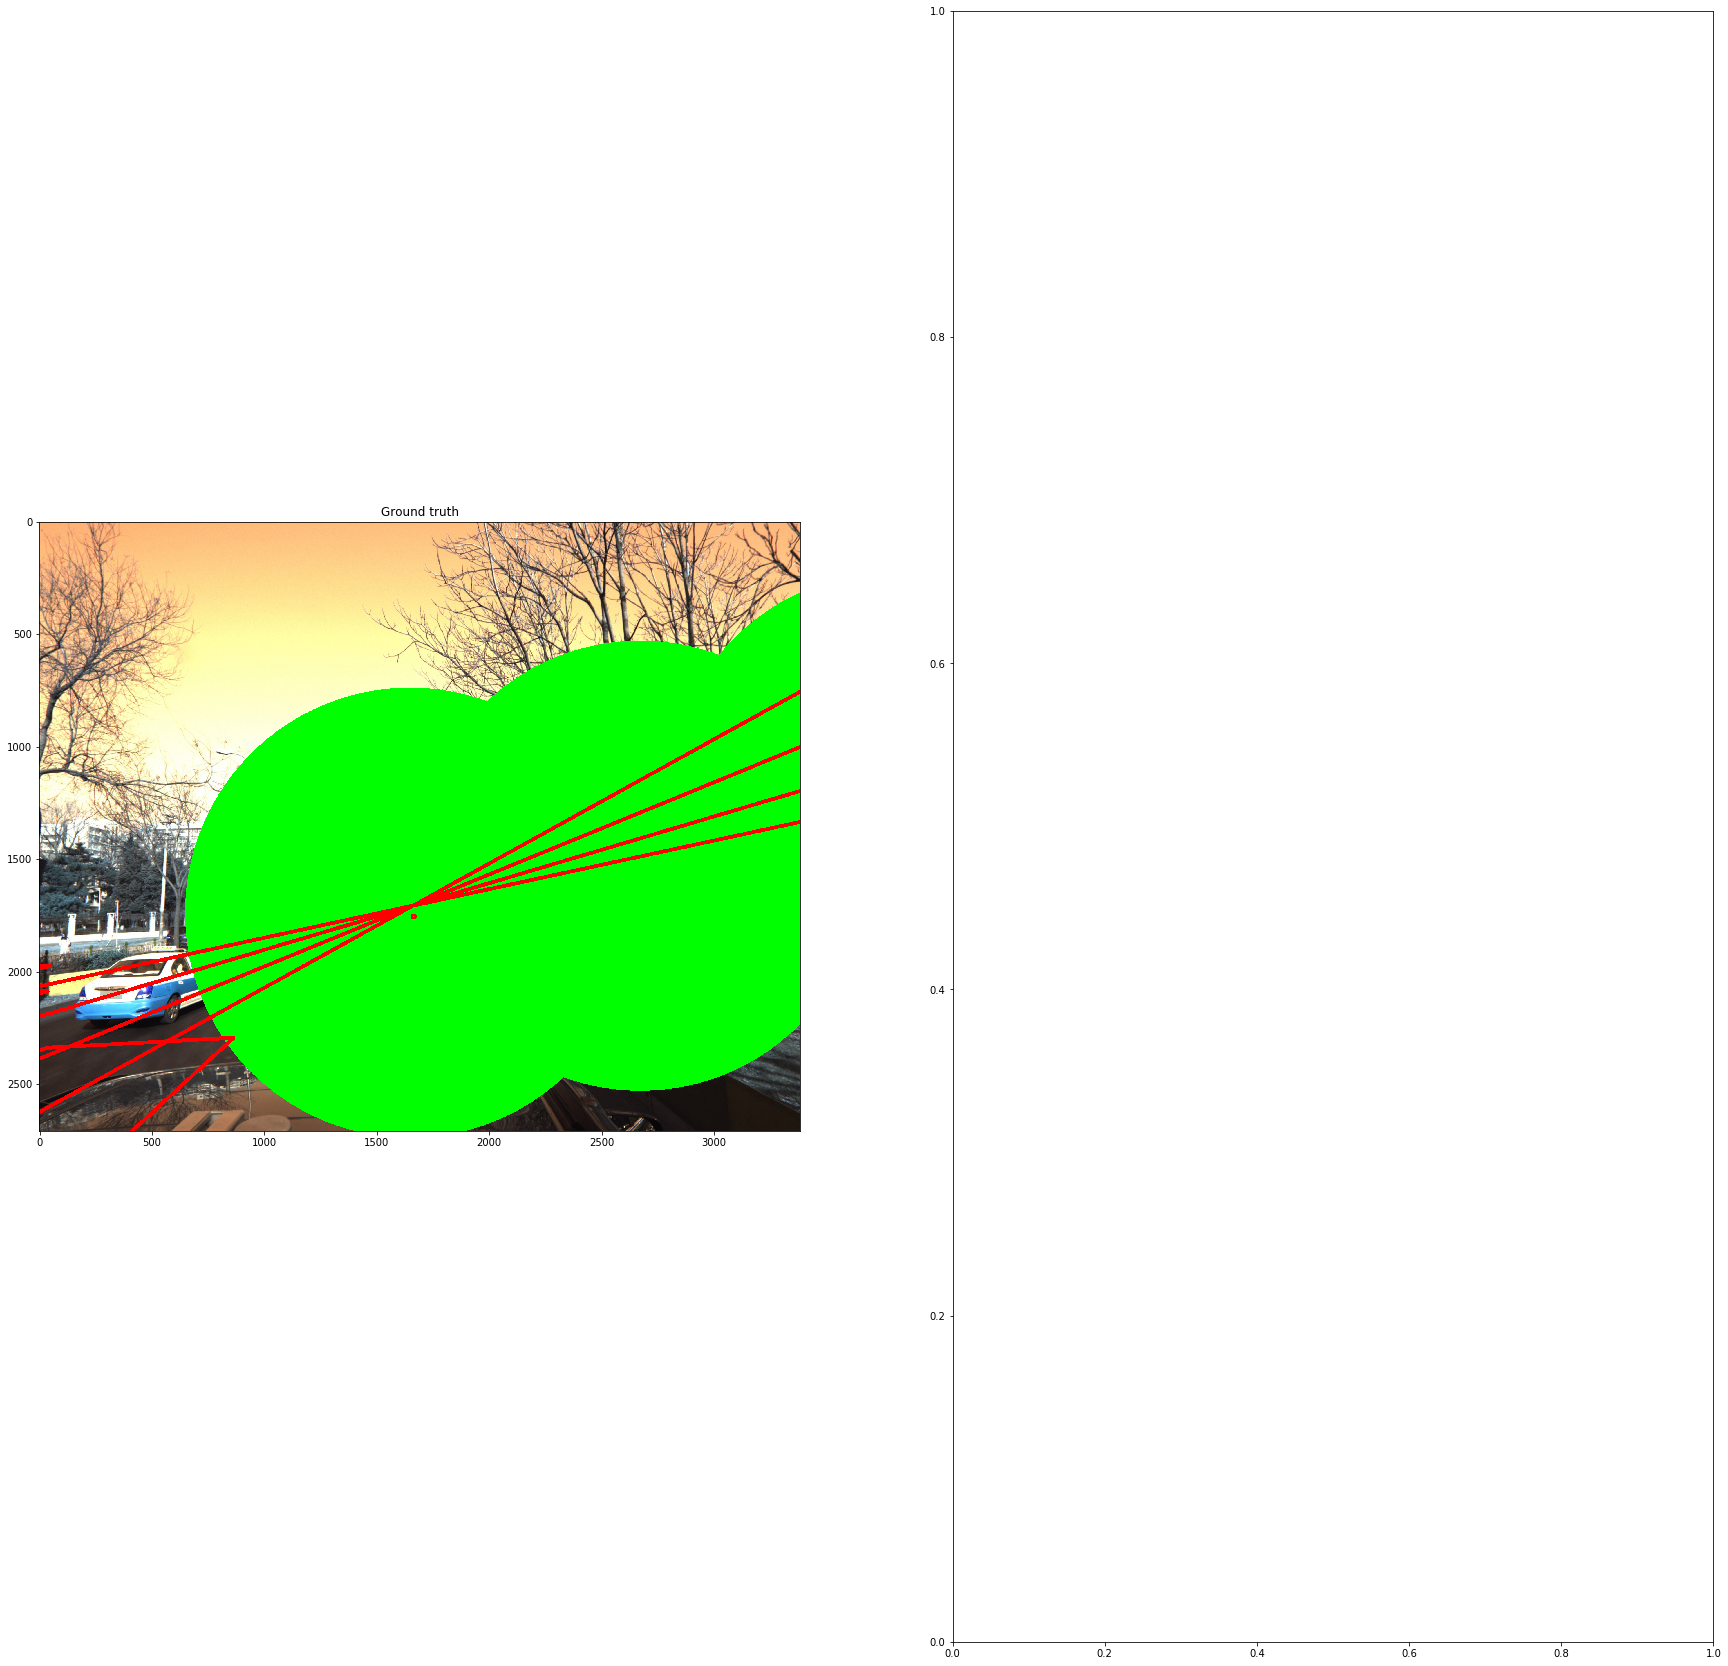

-16.2038 4.70015 23.9641
screen: [112  32   1]
source: [1.69375000e+03 9.66857143e+01 1.00000000e+00]
vehicle: [-52.77907016  11.24178899  76.51959499]
-16.2038 4.70015 23.9641
screen: [112  40   1]
source: [1.69375000e+03 1.20857143e+02 1.00000000e+00]
vehicle: [-54.12573821  11.70664172  79.68371259]
-16.2038 4.70015 23.9641
screen: [112  48   1]
source: [1.69375000e+03 1.45028571e+02 1.00000000e+00]
vehicle: [-55.58858071  12.21159639  83.12079249]
-16.2038 4.70015 23.9641
screen: [120  16   1]
source: [1.71794643e+03 4.83428571e+01 1.00000000e+00]
vehicle: [-29.32121093   6.4939098   41.25547124]
-16.2038 4.70015 23.9641
screen: [120  24   1]
source: [1.71794643e+03 7.25142857e+01 1.00000000e+00]
vehicle: [-29.52049759   6.635978    42.15802314]
-16.2038 4.70015 23.9641
screen: [120  32   1]
source: [1.71794643e+03 9.66857143e+01 1.00000000e+00]
vehicle: [-29.72869892   6.78440133  43.10094881]
-16.2038 4.70015 23.9641
screen: [120  40   1]
source: [1.71794643e+03 1.20857143e+02 1.

-19.6688 9.95285 57.1894
screen: [144 288   1]
source: [1.79053571e+03 8.70171429e+02 1.00000000e+00]
vehicle: [-9.5721504   5.10590384 27.03147199]
-19.6688 9.95285 57.1894
screen: [144 296   1]
source: [1.79053571e+03 8.94342857e+02 1.00000000e+00]
vehicle: [-9.42077862  5.17854586 27.41605047]
-19.6688 9.95285 57.1894
screen: [144 304   1]
source: [1.79053571e+03 9.18514286e+02 1.00000000e+00]
vehicle: [-9.26503753  5.25328467 27.81172973]
-22.9359 13.0731 76.7924
screen: [112 320   1]
source: [1.69375000e+03 9.66857143e+02 1.00000000e+00]
vehicle: [  55.6132079   -26.17385025 -178.15780231]
-22.9359 13.0731 76.7924
screen: [112 328   1]
source: [1.69375000e+03 9.91028571e+02 1.00000000e+00]
vehicle: [  49.19630077  -23.95881532 -163.0807024 ]
-22.9359 13.0731 76.7924
screen: [112 336   1]
source: [1.69375e+03 1.01520e+03 1.00000e+00]
vehicle: [  43.78074846  -22.08943537 -150.35637561]
-22.9359 13.0731 76.7924
screen: [120 312   1]
source: [1.71794643e+03 9.42685714e+02 1.00000000e

22.4751 7.43292 34.7913
screen: [ 136 1040    1]
source: [1.76633929e+03 3.14228571e+03 1.00000000e+00]
vehicle: [-28.82567095  -8.13897561 -45.62359572]
22.4751 7.43292 34.7913
screen: [ 136 1048    1]
source: [1.76633929e+03 3.16645714e+03 1.00000000e+00]
vehicle: [-28.62645088  -7.9507376  -44.56841442]
22.4751 7.43292 34.7913
screen: [ 136 1056    1]
source: [1.76633929e+03 3.19062857e+03 1.00000000e+00]
vehicle: [-28.43623762  -7.77100989 -43.5609382 ]
22.4751 7.43292 34.7913
screen: [ 136 1064    1]
source: [1.76633929e+03 3.21480000e+03 1.00000000e+00]
vehicle: [-28.25443385  -7.59922811 -42.59800345]
22.4751 7.43292 34.7913
screen: [ 144 1024    1]
source: [1.79053571e+03 3.09394286e+03 1.00000000e+00]
vehicle: [-56.83363959 -17.57448011 -93.04211009]
22.4751 7.43292 34.7913
screen: [ 144 1032    1]
source: [1.79053571e+03 3.11811429e+03 1.00000000e+00]
vehicle: [-55.14688817 -16.76502254 -88.75671222]
22.4751 7.43292 34.7913
screen: [ 144 1040    1]
source: [1.79053571e+03 3.1

17.791 5.26769 27.1096
screen: [ 136 1064    1]
source: [1.76633929e+03 3.21480000e+03 1.00000000e+00]
vehicle: [-28.25443385  -7.59922811 -42.59800345]
17.791 5.26769 27.1096
screen: [ 136 1072    1]
source: [1.76633929e+03 3.23897143e+03 1.00000000e+00]
vehicle: [-28.08049397  -7.43487671 -41.67672021]
17.791 5.26769 27.1096
screen: [ 136 1080    1]
source: [1.76633929e+03 3.26314286e+03 1.00000000e+00]
vehicle: [-27.91391854  -7.2774838  -40.79444325]
17.791 5.26769 27.1096
screen: [ 136 1088    1]
source: [1.76633929e+03 3.28731429e+03 1.00000000e+00]
vehicle: [-27.75424956  -7.12661661 -39.94874669]
17.791 5.26769 27.1096
screen: [ 144 1024    1]
source: [1.79053571e+03 3.09394286e+03 1.00000000e+00]
vehicle: [-56.83363959 -17.57448011 -93.04211009]
17.791 5.26769 27.1096
screen: [ 144 1032    1]
source: [1.79053571e+03 3.11811429e+03 1.00000000e+00]
vehicle: [-55.14688817 -16.76502254 -88.75671222]
17.791 5.26769 27.1096
screen: [ 144 1040    1]
source: [1.79053571e+03 3.14228571

[1.71794643e+03 5.31771429e+02 1.00000000e+00] [-28.94718543   6.22727314  39.56154242]
[1.71794643e+03 1.23274286e+03 1.00000000e+00] [-28.94718543   6.22727314  39.56154242]
[1.74214286e+03 6.76800000e+02 1.00000000e+00] [-20.66373336   4.74163321  28.24071328]
[1.74214286e+03 8.70171429e+02 1.00000000e+00] [-20.66373336   4.74163321  28.24071328]
[1.74214286e+03 9.91028571e+02 1.00000000e+00] [-20.66373336   4.74163321  28.24071328]
[1.74214286e+03 1.08771429e+03 1.00000000e+00] [-20.66373336   4.74163321  28.24071328]
[1.74214286e+03 1.13605714e+03 1.00000000e+00] [-20.66373336   4.74163321  28.24071328]
[1.74214286e+03 1.25691429e+03 1.00000000e+00] [-20.66373336   4.74163321  28.24071328]
[1.76633929e+03 1.78868571e+03 1.00000000e+00] [-16.06625515   3.91707394  21.95743127]
[1.79053571e+03 1.20857143e+02 1.00000000e+00] [-13.14223633   3.39265017  17.96123292]
[1.79053571e+03 3.19062857e+03 1.00000000e+00] [-13.14223633   3.39265017  17.96123292]
[1.79053571e+03 3.31148571e+03 1

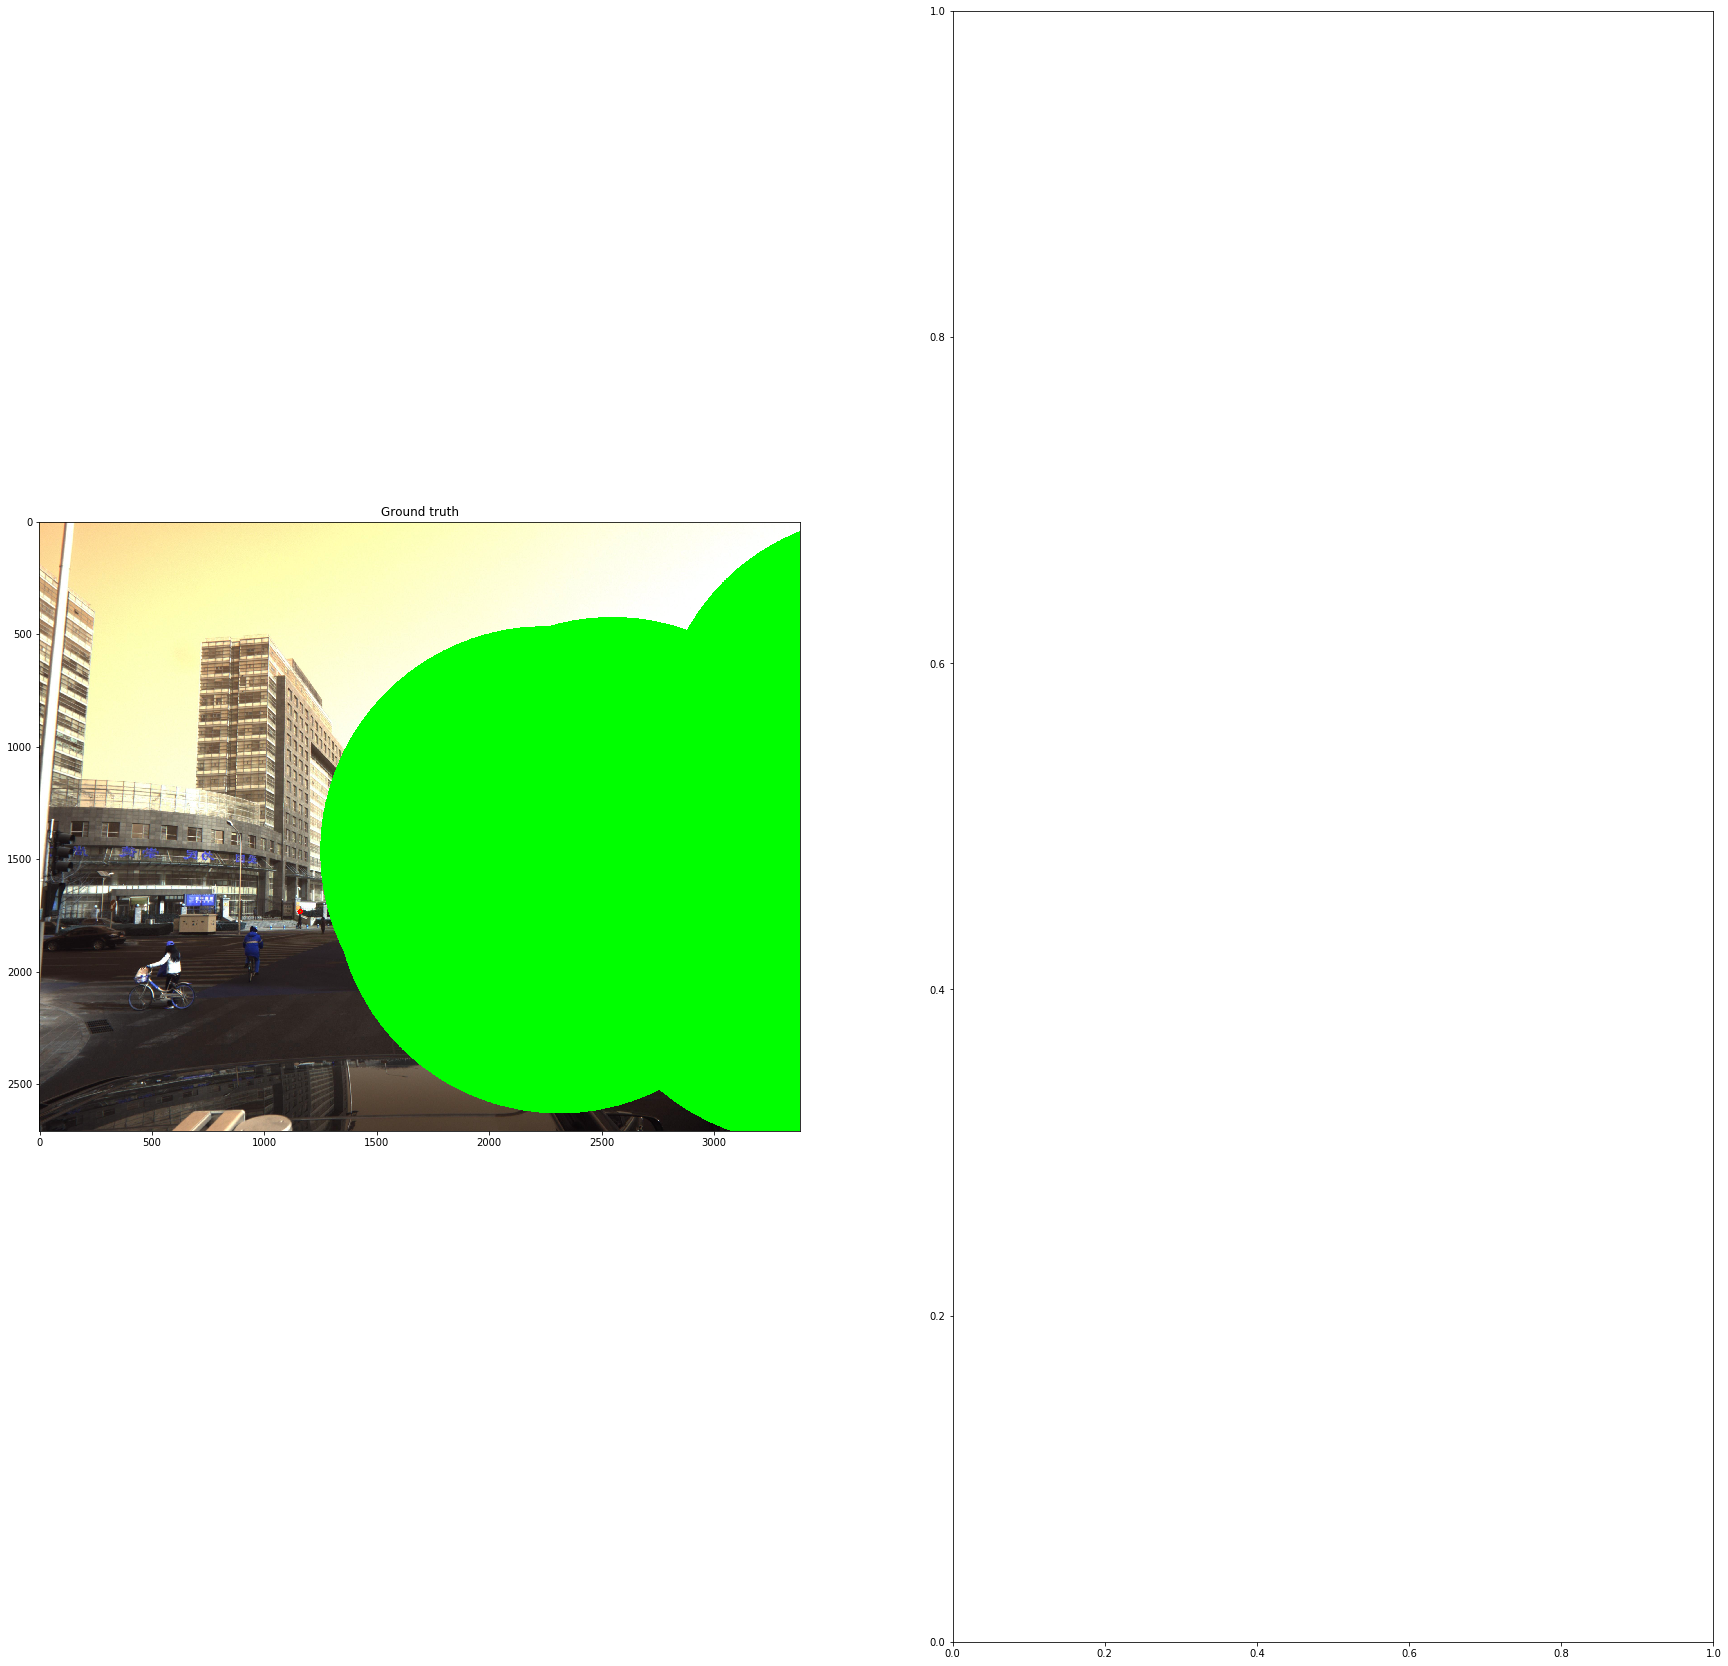

IndexError: list index out of range

In [39]:
import gc
gc.collect()

training.clean_up()
for idx in range(8):
    data = dev_loader.dataset[idx]
    img, mask, regr = data["img"], data["mask"], data["regr"]
    #output = model(torch.tensor(img[None]).to(device)).data.cpu().numpy()

    #coords_pred = util.extract_coords(data, output[0])
    coords_true = util.extract_coords(data)

    img = io.load_image(dev_loader.dataset.dataset[idx].image_id)
    img = img[:,::-1]
    fig, axes = plt.subplots(1, 2, figsize=(30,30))
    axes[0].set_title('Ground truth')
    axes[0].imshow(graphics.draw_coords(img, coords_true))
    #axes[1].set_title('Prediction')
    #axes[1].imshow(graphics.draw_coords(img, coords_pred))
    plt.show()